In [1]:
pacotes <- c("tidyverse","GetTDData")
for(i in pacotes){
    suppressPackageStartupMessages({
        library(i, character.only = T)
    })
}

In [2]:
curva <- get.yield.curve()

In [5]:
head(curva)

,n.biz.days,type,value,ref.date,current.date
,<dbl>,<chr>,<dbl>,<date>,<date>
1,252,real_return,-1.5812,2021-07-02,2020-10-23
2,378,real_return,-0.3378,2021-11-05,2020-10-23
3,504,real_return,0.5280,2022-03-11,2020-10-23
4,630,real_return,1.1258,2022-07-15,2020-10-23
5,756,real_return,1.5650,2022-11-18,2020-10-23
6,882,real_return,1.9085,2023-03-24,2020-10-23


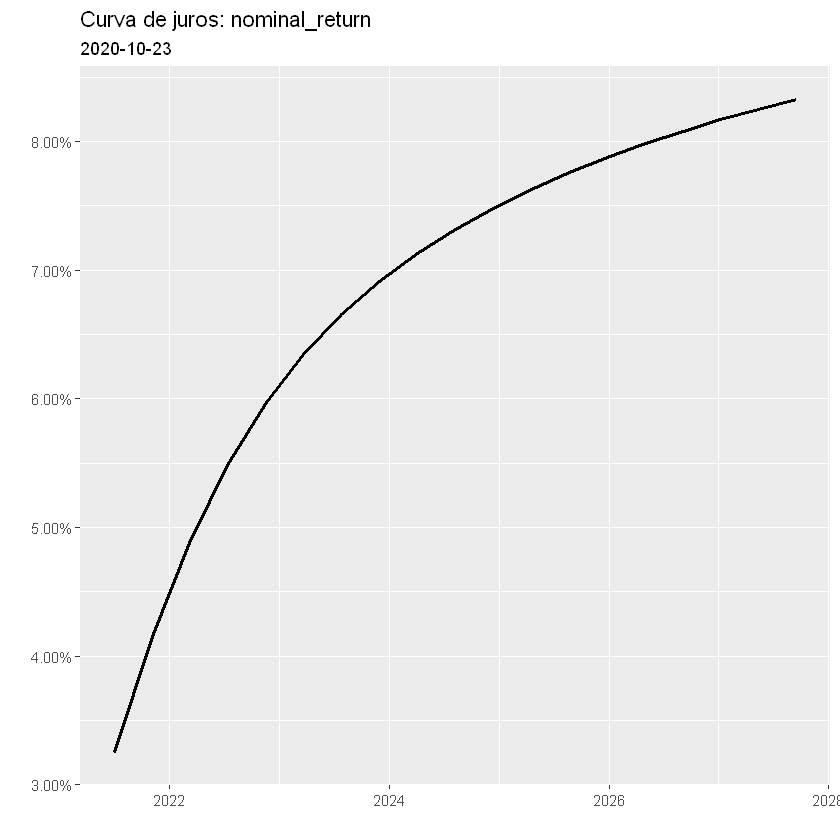

In [7]:
tipo <- "nominal_return"
curva %>%
   filter(type == tipo) %>%
   ggplot(aes(x = ref.date, y = value/100))+
   geom_line(size = 1)+
   scale_y_continuous(labels = scales::percent)+
   labs(x = "", y = "", title = paste("Curva de juros:",tipo), subtitle = paste(curva$current.date))

In [ ]:
get_bonds <- function(lista, inicio = "01/01/2016",
                      fim = format(Sys.Date(), "%d/%m/%Y")){
  suppressPackageStartupMessages({require(reticulate)
    require(tidyverse)})
  invest <- import("investpy", as = "invest")
  if(length(lista) > 1){
    listt <- replicate(length(lista), list())
    for(i in 1:length(lista)){
      data <- invest$get_bond_historical_data(lista[i], inicio, fim)
      dates <- rownames(data)
      rownames(data) <- NULL
      data <- cbind(dates, data)
      listt[[i]] <- data[,c(1,5)]
      colnames(listt[[i]]) <- c("Date", lista[i])
    }
    data1 <- left_join(listt[[1]], listt[[2]], by = c("Date" = "Date"))
    for(i in 3:length(lista)){
      data1 <- left_join(data1, listt[[i]], by = c("Date" = "Date"))
    }
    data1 <- data1 %>%
      gather(key = "bond", value = "rate", -Date)
    for(i in 1:nrow(data1)){
      if(grepl("3M", data1$bond[i])){
        data1$matur[i] <- 90
      }else if(grepl("6M", data1$bond[i])){
        data1$matur[i] <- 30*6
      }else if(grepl("9M", data1$bond[i])){
        data1$matur[i] <- 30*9
      }else if(grepl("1Y", data1$bond[i])){
        data1$matur[i] <- 365
      }else if(grepl("2Y", data1$bond[i])){
        data1$matur[i] <- 365*2
      }else if(grepl("3Y", data1$bond[i])){
        data1$matur[i] <- 365*3
      }else if(grepl("5Y", data1$bond[i])){
        data1$matur[i] <- 365*5
      }else if(grepl("8Y", data1$bond[i])){
        data1$matur[i] <- 365*8
      }else if(grepl("10Y", data1$bond[i])){
        data1$matur[i] <- 365*10
      }
    }
    data1$Date <- as.Date(data1$Date)
    data1$rate <- data1$rate/100
    data1$rate <- zoo::na.fill(data1$rate,"extend")
    return(data1)
  }else{
    data <- invest$get_bond_historical_data(lista, inicio, fim)
    dates <- rownames(data)
    rownames(data) <- NULL
    data <- cbind(dates, data)
    colnames(data) <- c("Date",colnames(data)[-1])
    return(data)
  }
}